# Equal Event Ratio Network
This notebook will use an equal event ratio along with the revised pre-selection criteria and suggested features from Dan and Paul. Hopefully this will vastly reduce any overfitting and massively improve generality of our model. We expect it to do worse in training because this is now a much more complex task. To speed things up we called in all the data and generated new features in the notebook reduced_feature_network and saved it as a CSV.

In [1]:
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from dataflow import Flow

In [2]:
data = Flow(None, None, None, 'csv/preselected_pKmue_fullFeatures_unequalRatio.csv')
data.set_event_ratio(1)
data.drop_features(['p_PZ', 'p_P', 'K_PZ', 'K_P', 'K_PY', 'K_PT', 'p_PY', 'p_PT', 'L2_IPCHI2_OWNPV', 'L1_IPCHI2_OWNPV', 'Lb_L1_cc_asy_PT_0.5ConeISO',
  'Lb_L2_cc_asy_PT_0.5ConeISO', 'Lb_p_cc_asy_PT_0.5ConeISO', 'Lb_K_cc_asy_PT_0.5ConeISO',], target='all')
# Remove features called in for feature engineering

data1 = Flow(None, None, None, "csv/preselected_pKmue_fullFeatures_equalRatio.csv")

## Network Architecture Setup
We will now move onto building our network. This requires us to define a network architecture. We will use a similar architecture to what was working well with the many features from before but simplify it a little. We will monitor the accuracy, loss, AUC and ROC curves for the network as it trains. Then we can start analysing features further and see how much each impacts event selection.

In [3]:
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import callbacks, layers, Sequential

In [4]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = data.get_train_val_test_split(0.6, 0.2, 0.2)
(X_train1, y_train1), (X_val1, y_val1), (X_test1, y_test1) = data1.get_train_val_test_split(0.6, 0.2, 0.2)

In [5]:
custom_callbacks = [
    callbacks.EarlyStopping(patience=20, min_delta=0.0005, restore_best_weights=True), 
    callbacks.ReduceLROnPlateau(patience=5, factor=0.2, min_lr=0.001)
    ]

def compile_model(input_shape):
    model = Sequential([
        layers.Dense(16, activation='relu', input_shape=input_shape, kernel_regularizer=l1_l2(0.001, 0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu', kernel_regularizer=l1_l2(0.001, 0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu', kernel_regularizer=l1_l2(0.001, 0.001)),
        layers.BatchNormalization(),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['binary_accuracy', 'AUC', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])
    
    return model

## Fitting the Model
Now we can start training the model. I will wrap it all up in a function so we can repeatedly call the same or very similar model architecture and thus compare models easily. For example adding a few features will only chnage the first layers input shape.

In [6]:
def fit_model(model, train_data, val_data, model_version, callbacks=None, epochs=100, batch_size=512):
    model_history = model.fit(train_data[0], train_data[1], epochs=epochs, batch_size=batch_size, validation_data=val_data, callbacks=callbacks)
    with open(f'train_history/v{model_version}', 'wb') as file_pi:
        pickle.dump(model_history.history, file_pi)
    model.save(f'models/v{model_version}')

In [7]:
model = compile_model((X_train.shape[1],))
fit_model(model, (X_train, y_train), (X_val, y_val), '3.0.0', callbacks=custom_callbacks)

2022-02-17 08:23:53.770922: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-17 08:23:53.788845: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-02-17 08:23:54.242850: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-17 08:23:54.267745: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2400145000 Hz


Epoch 1/100
56/56 [==============================] - 5s 29ms/step - loss: 0.8704 - binary_accuracy: 0.8064 - auc: 0.8842 - true_positives: 11602.0000 - true_negatives: 11249.0000 - false_positives: 2908.0000 - false_negatives: 2579.0000 - val_loss: 0.9195 - val_binary_accuracy: 0.8613 - val_auc: 0.9377 - val_true_positives: 3981.0000 - val_true_negatives: 4156.0000 - val_false_positives: 554.0000 - val_false_negatives: 756.0000
Epoch 2/100
56/56 [==============================] - 1s 16ms/step - loss: 0.7192 - binary_accuracy: 0.8596 - auc: 0.9277 - true_positives: 12372.0000 - true_negatives: 11988.0000 - false_positives: 2169.0000 - false_negatives: 1809.0000 - val_loss: 0.7625 - val_binary_accuracy: 0.8711 - val_auc: 0.9446 - val_true_positives: 4122.0000 - val_true_negatives: 4107.0000 - val_false_positives: 603.0000 - val_false_negatives: 615.0000
Epoch 3/100
56/56 [==============================] - 1s 13ms/step - loss: 0.6381 - binary_accuracy: 0.8707 - auc: 0.9363 - true_positive

2022-02-17 08:25:22.892869: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/v3.0.0/assets


In [8]:
model1 = compile_model((X_train1.shape[1],))
fit_model(model1, (X_train1, y_train1), (X_val1, y_val1), '3.0.1', callbacks=custom_callbacks)

Epoch 1/100
56/56 [==============================] - 4s 27ms/step - loss: 0.8276 - binary_accuracy: 0.8270 - auc: 0.9041 - true_positives: 12095.0000 - true_negatives: 11340.0000 - false_positives: 2817.0000 - false_negatives: 2086.0000 - val_loss: 0.8942 - val_binary_accuracy: 0.8695 - val_auc: 0.9441 - val_true_positives: 4150.0000 - val_true_negatives: 4064.0000 - val_false_positives: 646.0000 - val_false_negatives: 587.0000
Epoch 2/100
56/56 [==============================] - 1s 14ms/step - loss: 0.6804 - binary_accuracy: 0.8705 - auc: 0.9381 - true_positives: 12514.0000 - true_negatives: 12155.0000 - false_positives: 2002.0000 - false_negatives: 1667.0000 - val_loss: 0.7255 - val_binary_accuracy: 0.8804 - val_auc: 0.9521 - val_true_positives: 4322.0000 - val_true_negatives: 3995.0000 - val_false_positives: 715.0000 - val_false_negatives: 415.0000
Epoch 3/100
56/56 [==============================] - 1s 15ms/step - loss: 0.5982 - binary_accuracy: 0.8807 - auc: 0.9449 - true_positive

In [9]:
def plot_history_curves(history, epochs, model_version='No version'):
    if type(history) != dict:
        history = history.history
    
    loss = history['loss']
    val_loss = history['val_loss']
    accuracy = history['binary_accuracy']
    val_accuracy = history['val_binary_accuracy']
    auc = history['auc']
    val_auc = history['val_auc']
    epoch_range = range(1, epochs+1, 1)    

    fig, ax = plt.subplots(1, 3, figsize=(22, 6))
    ax[0].plot(epoch_range, loss, 'r.', label='Training Loss')
    ax[0].plot(epoch_range, val_loss, 'b.', label='Validation Loss')
    ax[1].plot(epoch_range, accuracy, 'r.', label='Training Accuracy')
    ax[1].plot(epoch_range, val_accuracy, 'b.', label='Validation Accuracy')
    ax[2].plot(epoch_range, auc, 'r.', label='Training AUC')
    ax[2].plot(epoch_range, val_auc, 'b.', label='Validation AUC')
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    plt.title(model_version)
    plt.legend(frameon=False)
    plt.show()

def plot_history(model_version):
    history = pickle.load(open(f'train_history/v{model_version}', "rb"))
    nepochs = len(history['loss'])
    plot_history_curves(history, nepochs, model_version)
    

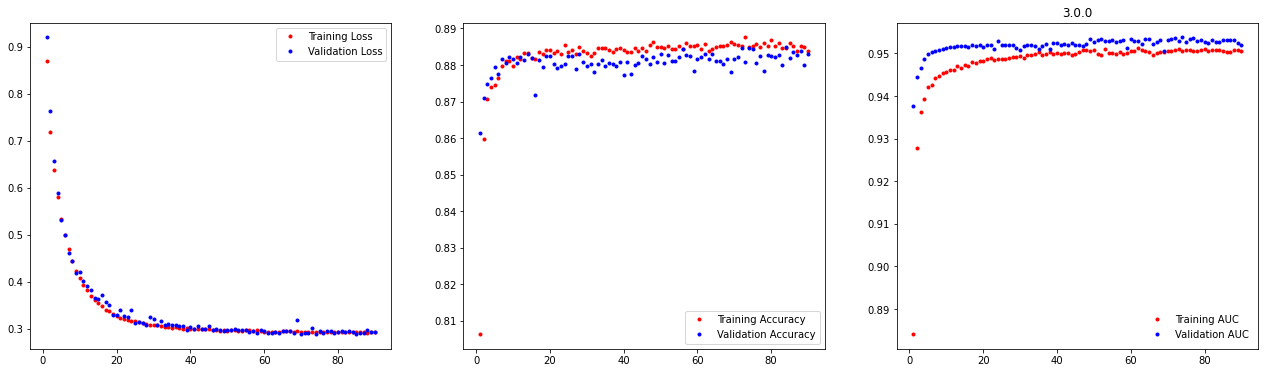

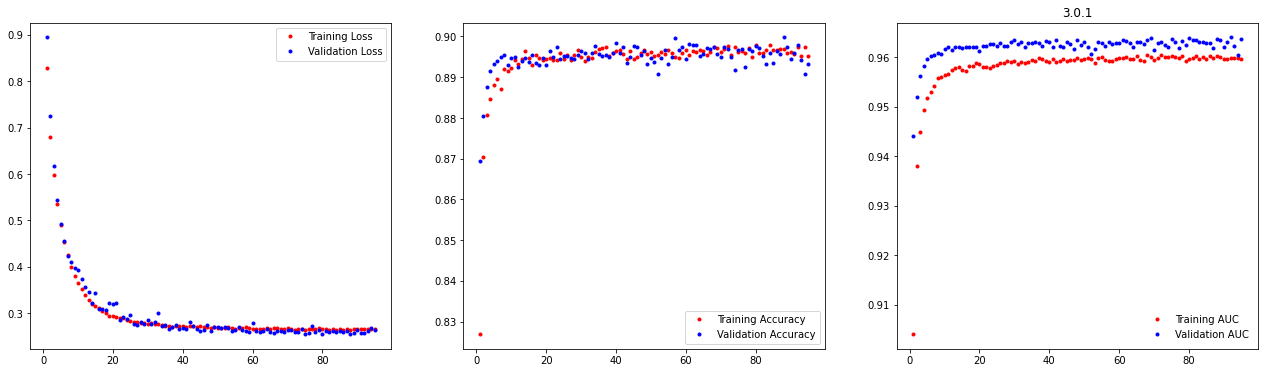

In [10]:
plot_history('3.0.0')
plot_history('3.0.1')

## Restricted Sidebands
Now we will investigate by further reducing our dataset size by restricting the mass region of the background sideband we include in our data. 